# Evaluate classification accuracy

This notebook demonstrates how to evaluate classification accuracy of "cross-validated" simulated communities. Due to the unique nature of this analysis, the metrics that we use to evaluate classification accuracy are different from those used for mock.

The key measure here is rate of ``match`` vs. ``overclassification``, hence P/R/F are not useful metrics. Instead, we define and measure the following as percentages:
* Match vs. overclassification rate
    * Match: exact match at level L
    * underclassification: lineage assignment is correct, but shorter than expected (e.g., not to species level)
    * misclassification: incorrect assignment
    
Where ``L`` = taxonomic level being tested


## Functions

In [8]:
from tax_credit.framework_functions import (novel_taxa_classification_evaluation,
                                            extract_per_level_accuracy)
from tax_credit.eval_framework import parameter_comparisons
from tax_credit.plotting_functions import (pointplot_from_data_frame,
                                           heatmap_from_data_frame,
                                           per_level_kruskal_wallis,
                                           rank_optimized_method_performance_by_dataset)
import seaborn.xkcd_rgb as colors
import pandas as pd
from os.path import expandvars, join, exists
from glob import glob
from IPython.display import display, Markdown

## Evaluate classification results
First, enter in filepaths and directory paths where your data are stored, and the destination

In [9]:
project_dir = "../.."
analysis_name = "cross-validated"
precomputed_results_dir = join(project_dir, "data", "precomputed-results", analysis_name)
expected_results_dir = join(project_dir, "data", analysis_name)
summary_fp = join(precomputed_results_dir, 'evaluate_classification_summary.csv')

results_dirs = glob(join(precomputed_results_dir, '*', '*', '*', '*'))

This cell performs the classification evaluation and should not be modified.

In [10]:
force = False
if force or not exists(summary_fp):
    accuracy_results = novel_taxa_classification_evaluation(results_dirs, expected_results_dir,
                                                            summary_fp, test_type='cross-validated')
else:
    accuracy_results = pd.DataFrame.from_csv(summary_fp)

# Plot classification accuracy
Finally, we plot our results. Line plots show the mean +/- 95% confidence interval for each classification result at each taxonomic level (1 = phylum, 6 = species) in each dataset tested. Do not modify the cell below, except to adjust the color_pallette used for plotting. This palette can be a dictionary of colors for each group, as shown below, or a [seaborn color palette](http://seaborn.pydata.org/tutorial/color_palettes.html).

**match_ratio** = proportion of correct matches.

**underclassification_ratio** = proportion of assignments to correct lineage but to a lower level than expected.

**misclassification_ratio** = proportion of assignments to an incorrect lineage.

In [11]:
color_palette={
    'expected': 'black', 'rdp': colors['baby shit green'], 'sortmerna': colors['macaroni and cheese'],
    'uclust': 'coral', 'blast': 'indigo', 'blast+': colors['electric purple'], 'naive-bayes': 'dodgerblue',
    'naive-bayes-bespoke': 'blue', 'vsearch': 'firebrick'
}

level_results = extract_per_level_accuracy(accuracy_results)

y_vars = ['Precision', 'Recall', 'F-measure']

In [12]:
pointplot_from_data_frame(level_results, "level", y_vars,
                          group_by="Dataset", color_by="Method",
                          color_palette=color_pallette)

KeyError: 'naive-bayes-bespoke'

## Naive-Bayes k-mer length picker

In [13]:
from pandas import DataFrame, concat, to_numeric

In [14]:
nb_results = level_results[level_results['Method'] == 'naive-bayes']
nb_results = nb_results.reset_index(drop=True)
columns = ['Alpha', 'kmer', 'Confidence']
def decode_params(p):
    p = p.split(':')
    p[-2] = int(eval(p[-2])[0])
    return p
params = DataFrame((decode_params(s) for s in nb_results['Parameters']), columns=columns)
keepers = ['Dataset', 'level', 'Method']
metrics = ['Precision', 'Recall', 'F-measure']
raw_param_results = concat([nb_results[keepers + metrics], params], axis=1)
raw_param_results = raw_param_results.apply(to_numeric, errors='ignore')
param_results = raw_param_results.groupby(keepers + columns, as_index=False).mean()
param_results.level = param_results.level.astype(int)
param_results.kmer = param_results.kmer.astype(int)
len(param_results)

1296

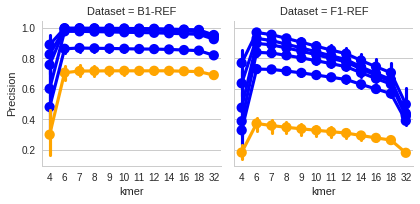

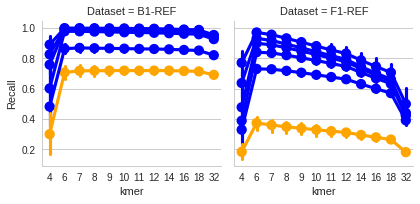

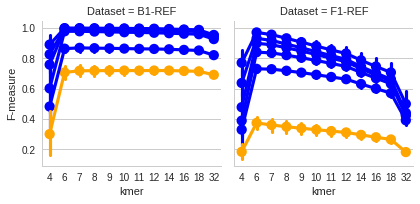

{'F-measure': <seaborn.axisgrid.FacetGrid at 0x7fa9c6b19a20>,
 'Precision': <seaborn.axisgrid.FacetGrid at 0x7fa9ca6766d8>,
 'Recall': <seaborn.axisgrid.FacetGrid at 0x7fa9ca2525f8>}

In [15]:
level_pallete = {n:'blue' for n in range(1,6)}
level_pallete[6] = 'orange'
pointplot_from_data_frame(param_results, "kmer", y_vars, 
                          group_by="Dataset", color_by="level",
                          color_palette=level_pallete)

## Per-level classification accuracy statistic
Kruskal-Wallis FDR-corrected p-values comparing classification methods at each level of taxonomic assignment

In [17]:
result = per_level_kruskal_wallis(level_results, y_vars, group_by='Method', 
                                  dataset_col='Dataset', alpha=0.05, 
                                  pval_correction='fdr_bh')
result

,Dataset,Variable,1,2,3,4,5,6
0,B1-REF,Precision,5.415276e-03,1.167548e-01,7.945862e-20,6.120104e-10,3.674093e-18,1.191819e-15
1,B1-REF,Recall,8.646268e-22,1.737241e-21,4.183030e-23,7.505660e-21,1.023730e-12,1.244342e-10
2,B1-REF,F-measure,3.576752e-22,9.935459e-22,7.783520e-26,3.665289e-21,6.784682e-21,1.569797e-26
3,F1-REF,Precision,2.975429e-37,8.712832e-44,1.581147e-46,3.632389e-40,4.066763e-29,6.820908e-19
4,F1-REF,Recall,4.740560e-38,3.632389e-40,3.922101e-40,1.537953e-40,4.736284e-42,6.113875e-39
5,F1-REF,F-measure,4.740560e-38,1.013492e-40,6.337137e-41,5.051777e-42,4.284161e-46,2.968640e-53


## Heatmaps of method accuracy by parameter
Heatmaps show the performance of individual method/parameter combinations at each taxonomic level, in each reference database (i.e., for bacterial and fungal simulated datasets individually).

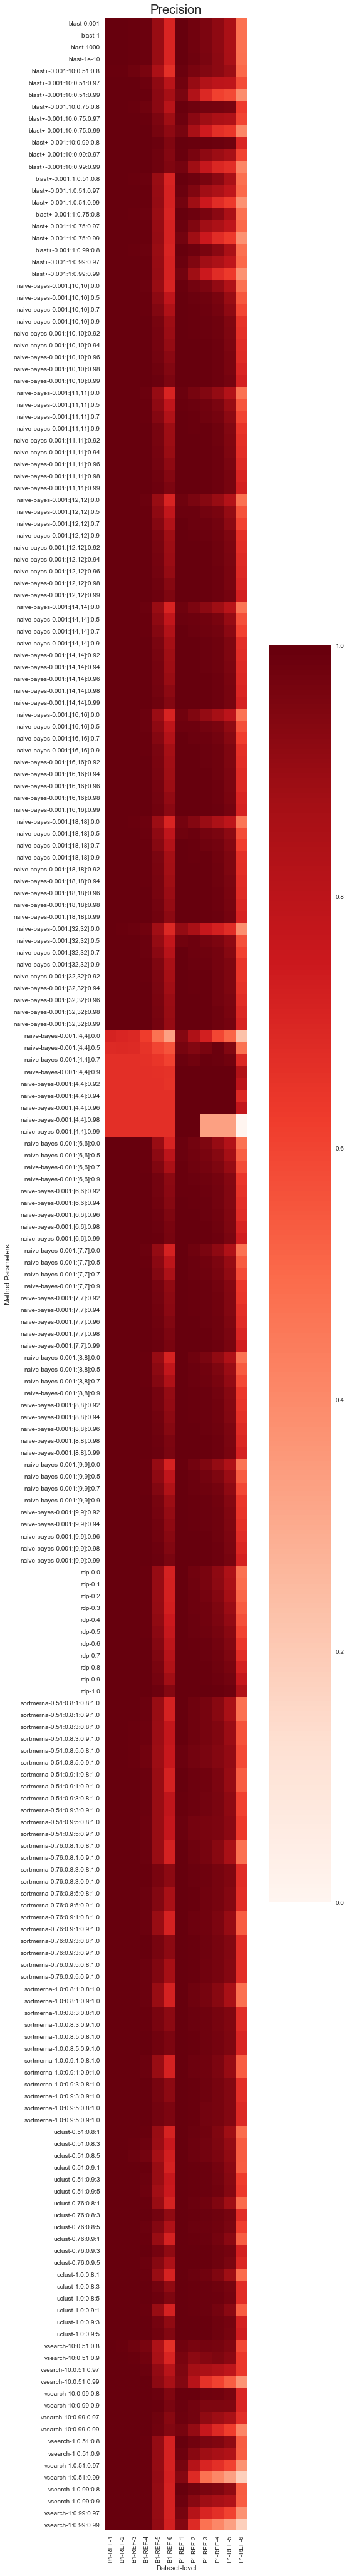

In [18]:
heatmap_from_data_frame(level_results, metric="Precision", rows=["Method", "Parameters"], cols=["Dataset", "level"])

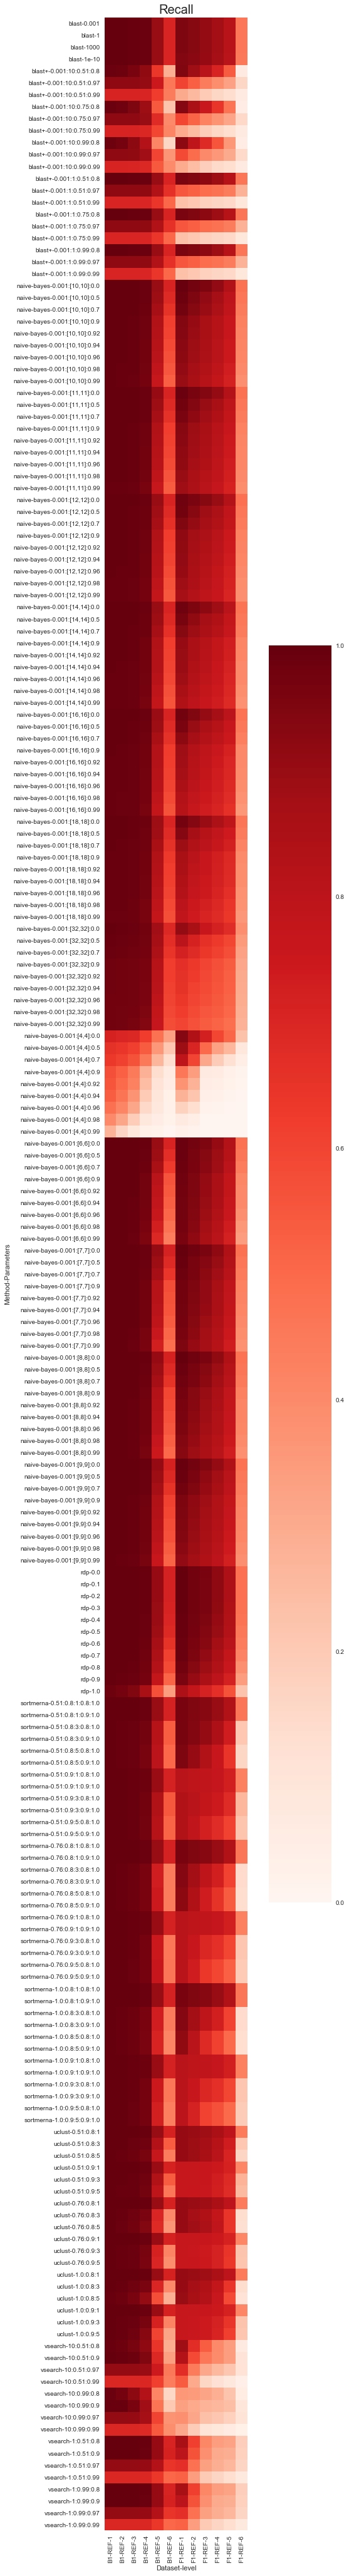

In [19]:
heatmap_from_data_frame(level_results, metric="Recall", rows=["Method", "Parameters"], cols=["Dataset", "level"])

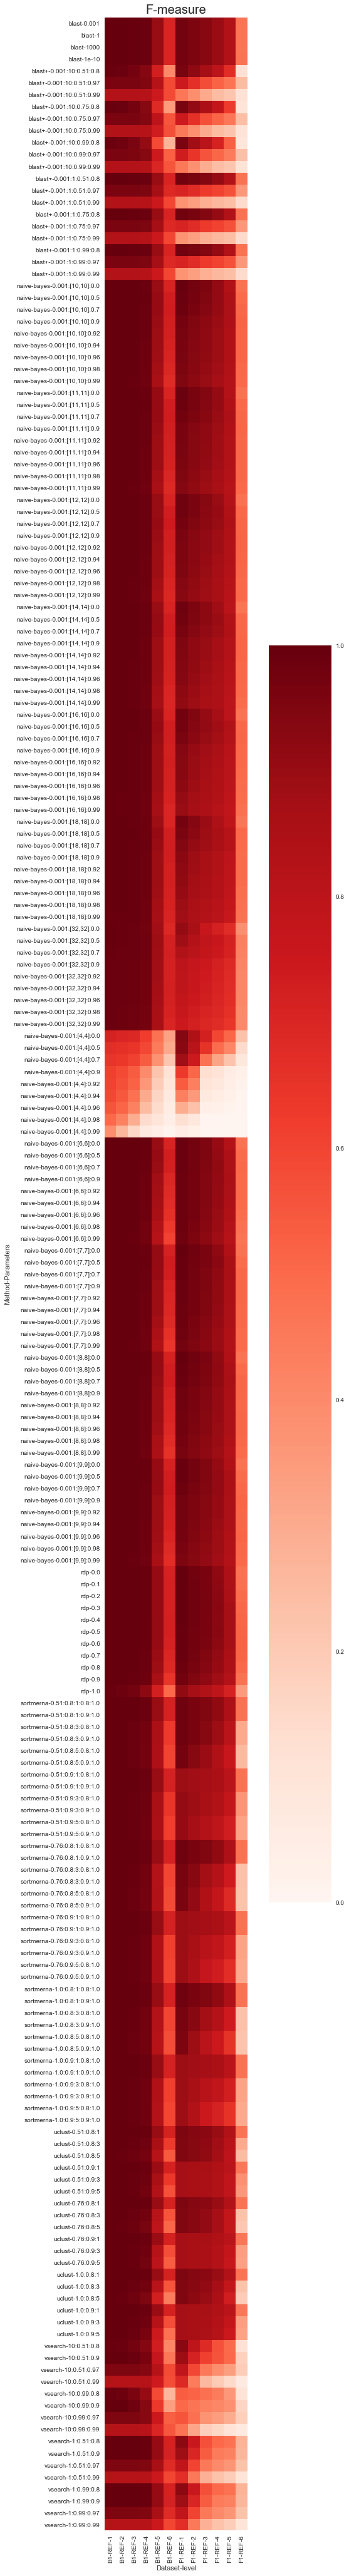

In [20]:
heatmap_from_data_frame(level_results, metric="F-measure", rows=["Method", "Parameters"], cols=["Dataset", "level"])

## Rank-based statistics comparing the performance of the optimal parameter setting run for each method on each data set.
Rank parameters for each method to determine the best parameter configuration within each method. *Count best* values in each column indicate how many samples a given method achieved within one mean absolute deviation of the best result (which is why they may sum to more than the total number of samples).

In [21]:
for method in level_results['Method'].unique():
    top_params = parameter_comparisons(level_results, method, metrics=y_vars, 
                                       sample_col='Dataset', method_col='Method',
                                       dataset_col='Dataset')
    display(Markdown('## {0}'.format(method)))
    display(top_params[:10])

## blast

,F-measure,Precision,Recall
0.001,24,24,24
1,24,24,24
1000,24,24,24
1e-10,24,25,24


## blast+

,F-measure,Precision,Recall
0.001:1:0.51:0.8,30.0,25,30.0
0.001:1:0.75:0.8,30.0,25,30.0
0.001:1:0.99:0.8,30.0,25,30.0
0.001:10:0.51:0.8,24.0,27,22.0
0.001:10:0.75:0.8,24.0,27,21.0
0.001:10:0.99:0.8,21.0,32,16.0
0.001:10:0.75:0.97,13.0,27,12.0
0.001:10:0.99:0.97,13.0,31,12.0
0.001:10:0.51:0.97,13.0,18,12.0
0.001:1:0.51:0.97,12.0,23,13.0


## naive-bayes

,F-measure,Precision,Recall
"0.001:[10,10]:0.0",30.0,24,30.0
"0.001:[9,9]:0.9",30.0,30,26.0
"0.001:[9,9]:0.7",30.0,30,28.0
"0.001:[9,9]:0.5",30.0,29,28.0
"0.001:[9,9]:0.0",30.0,25,30.0
"0.001:[8,8]:0.98",30.0,33,23.0
"0.001:[8,8]:0.96",30.0,32,24.0
"0.001:[8,8]:0.94",30.0,32,24.0
"0.001:[8,8]:0.92",30.0,31,24.0
"0.001:[8,8]:0.9",30.0,31,26.0


## rdp

,F-measure,Precision,Recall
0.5,29,28,26
0.6,27,29,25
0.1,26,24,28
0.2,26,24,28
0.3,26,25,27
0.4,26,27,27
0.0,25,24,28
0.7,25,29,23
0.8,24,30,22
0.9,24,30,20


## sortmerna

,F-measure,Precision,Recall
0.51:0.8:1:0.8:1.0,28,24,30
0.76:0.8:1:0.8:1.0,28,24,30
1.0:0.8:1:0.9:1.0,28,24,30
1.0:0.8:1:0.8:1.0,28,24,30
0.51:0.8:1:0.9:1.0,28,24,30
0.76:0.8:1:0.9:1.0,28,24,30
1.0:0.9:1:0.9:1.0,27,26,18
1.0:0.9:1:0.8:1.0,27,26,18
0.76:0.9:1:0.9:1.0,27,26,18
0.76:0.9:1:0.8:1.0,27,26,18


## uclust

,F-measure,Precision,Recall
0.51:0.8:1,30,25,30
0.76:0.8:1,30,25,30
1.0:0.8:1,30,25,30
1.0:0.9:1,27,27,22
0.76:0.9:1,27,27,22
0.51:0.9:1,27,27,22
0.51:0.8:3,26,26,25
0.51:0.9:3,25,27,20
0.51:0.8:5,25,27,24
0.51:0.9:5,24,27,18


## vsearch

,F-measure,Precision,Recall
1:0.51:0.8,19.0,27,18.0
1:0.99:0.8,19.0,27,18.0
10:0.51:0.8,18.0,27,15.0
1:0.51:0.9,18.0,25,18.0
1:0.99:0.9,18.0,25,18.0
1:0.51:0.97,16.0,16,13.0
1:0.99:0.97,16.0,16,13.0
10:0.51:0.9,15.0,27,15.0
10:0.51:0.97,15.0,25,12.0
10:0.99:0.8,12.0,32,10.0


## Rank performance of optimized methods
Now we rank the top-performing method/parameter combination for each method at genus and species levels. Methods are ranked by top F-measure, and the average value for each metric is shown (rather than count best as above). F-measure distributions are plotted for each method, and compared using paired t-tests with FDR-corrected P-values. This cell does not need to be altered, unless if you wish to change the *metric* used for sorting best methods and for plotting.

## B1-REF level 6

,Method,Parameters,Precision,Recall,F-measure
2,naive-bayes,"0.001:[12,12]:0.7",0.835557,0.661583,0.738438
3,rdp,0.5,0.768803,0.688224,0.726264
4,sortmerna,0.51:0.8:1:0.8:1.0,0.716966,0.716966,0.716966
6,vsearch,1:0.51:0.9,0.718555,0.711366,0.714934
5,uclust,0.76:0.9:1,0.716053,0.713440,0.714742
1,blast+,0.001:1:0.51:0.8,0.707120,0.707120,0.707120
0,blast,0.001,0.706130,0.706130,0.706130


stat         P     FDR P
Method A    Method B                                  
blast       blast+       -0.409002  0.722177  0.842540
            naive-bayes -52.795551  0.000359  0.007530
            rdp          -6.091164  0.025910  0.145327
            sortmerna    -1.886742  0.199829  0.350617
            uclust       -0.950664  0.442113  0.580273
            vsearch      -1.883311  0.200353  0.350617
blast+      naive-bayes -10.332473  0.009237  0.096991
            rdp          -3.510856  0.072425  0.200626
            sortmerna    -2.715465  0.113074  0.259374
            uclust       -0.848105  0.485693  0.599974
            vsearch      -1.253957  0.336559  0.504839
naive-bayes rdp           4.270069  0.050709  0.177480
            sortmerna     3.406454  0.076429  0.200626
            uclust        2.574747  0.123511  0.259374
            vsearch       5.305022  0.033744  0.145327
rdp         sortmerna     1.034240  0.409695  0.573573
            uclust        1.415907  0.292470  0.472452
            vsearch       5.235373  0.034602  0.145327
sortmerna   uclust        0.188965  0.867558  0.910936
            vsearch       0.206179  0.855734  0.910936
uclust      vsearch      -0.031256  0.977904  0.977904

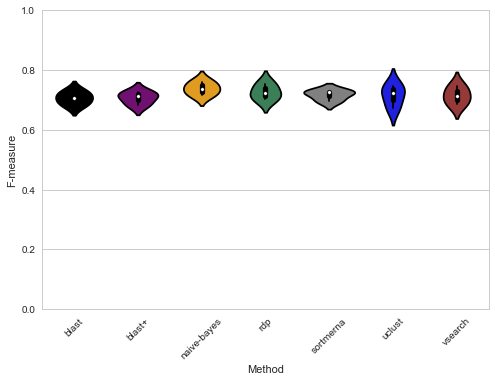

## F1-REF level 6

,Method,Parameters,Precision,Recall,F-measure
3,rdp,0.6,0.641409,0.437584,0.520174
2,naive-bayes,"0.001:[12,12]:0.9",0.663155,0.425015,0.517631
4,sortmerna,0.76:0.9:1:0.8:1.0,0.532502,0.429327,0.475340
1,blast+,0.001:1:0.51:0.8,0.483558,0.464441,0.473801
0,blast,1e-10,0.483897,0.456713,0.469903
5,uclust,0.51:0.8:1,0.494443,0.446836,0.469426
6,vsearch,1:0.51:0.8,0.536621,0.186967,0.277123


stat         P     FDR P
Method A    Method B                                  
blast       blast+       -1.542053  0.263004  0.324888
            naive-bayes  -4.497582  0.046048  0.074385
            rdp          -6.683029  0.021665  0.056871
            sortmerna    -9.206773  0.011593  0.034778
            uclust        0.146873  0.896701  0.896701
            vsearch      13.272084  0.005629  0.021433
blast+      naive-bayes  -3.486466  0.073333  0.102666
            rdp          -4.672823  0.042874  0.074385
            sortmerna    -0.793668  0.510595  0.564342
            uclust        1.354978  0.308177  0.359540
            vsearch      15.393509  0.004194  0.021433
naive-bayes rdp          -0.548114  0.638618  0.670549
            sortmerna     3.834759  0.061769  0.092653
            uclust        4.828706  0.040313  0.074385
            vsearch      12.929809  0.005928  0.021433
rdp         sortmerna     5.558771  0.030872  0.064831
            uclust        6.100826  0.025831  0.060272
            vsearch      12.720154  0.006124  0.021433
sortmerna   uclust        1.949461  0.190558  0.250108
            vsearch      14.082840  0.005004  0.021433
uclust      vsearch      16.527530  0.003641  0.021433

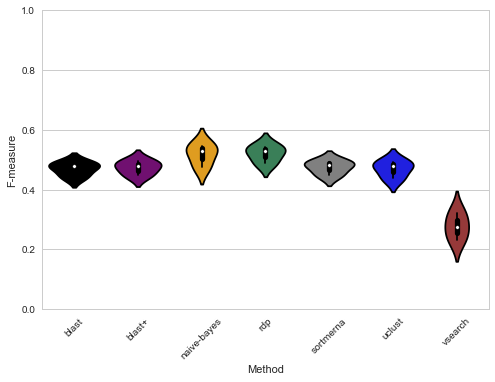

In [22]:
rank_optimized_method_performance_by_dataset(level_results,
                                             metric="F-measure",
                                             level="level",
                                             level_range=range(6,7),
                                             display_fields=["Method",
                                                             "Parameters",
                                                             "Precision",
                                                             "Recall",
                                                             "F-measure"],
                                             paired=True,
                                             parametric=True,
                                             color=None,
                                             color_pallette=color_pallette)